<a href="https://colab.research.google.com/github/Just-Aymz/US-Insurance-Data/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**
___


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
from typing import Literal, Optional

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler,
    PowerTransformer
)
from scipy.stats import kurtosis, skew, shapiro
from scipy import stats

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import set_config


import pickle


# **Read Files**
___

In [2]:
# read in the dataset
df = pd.read_csv('insurance.csv')

# **Dataset Identification**
___

In [3]:
# Return the shape and size of the dataset
print(f'Shape of the dataset: {df.shape}\nSize of the dataset: {df.size}')

Shape of the dataset: (1338, 7)
Size of the dataset: 9366


In [4]:
# Return the axes of the dataset
df.axes

[RangeIndex(start=0, stop=1338, step=1),
 Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')]

In [5]:
# Return the datatypes of each feature
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
# Return an overview of the top 3 rows
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [7]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [8]:
# Return an overview of the last 3 rows
df.tail(3)

,age,sex,bmi,children,smoker,region,charges
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


# **Data Preprocessing**
___

## 1. **Data Cleaning**
___


In [9]:
def data_Cleaning(
    method: Literal['duplicates', 'nulls'],
    dataframe: Optional[pd.DataFrame]=df
) -> None:
  if method == 'duplicates':
    dupes = df.duplicated().sum()
    if dupes > 1:
      print(f'There are a total of {dupes} duplicates in the dataset')
    else:
      print('There are no duplicate values within the dataset')

  else:
    nulls = np.count_nonzero(df.isnull().values)
    if nulls > 1:
      print(f'There are a total of {dupes} null values in the dataset')
    else:
      print('There are no null values within the dataset')


### 1.1 **Duplicate Values**

In [10]:
data_Cleaning('duplicates')

There are no duplicate values within the dataset


### 1.2 **Null Values**

In [11]:
data_Cleaning('nulls')

There are no null values within the dataset


### 1.3 **Outlier Values**

In [12]:
def outlier_Values(feature: str, dataframe: Optional[pd.DataFrame]=df):
  # Store the q1 and q3 values
  q1 = dataframe[feature].quantile(0.25)
  q3 = dataframe[feature].quantile(0.75)

  # Find the IQR Value
  IQR = q3 - q1

  # Find the upper and lower limits for the outlier values
  upper = dataframe[feature] > q3 + (IQR * 1.5)
  lower = dataframe[feature] < q1 - (IQR * 1.5)

  # Store the total number of outliers in the feature
  outliers = dataframe[feature][upper | lower].index.tolist()

  if len(outliers) > 0:
    print(f'Column: {feature}\nOutliers: {len(outliers)}\n')
    return feature
  else:
    print(f'Column {feature} has no outliers\n')

In [13]:
outliers = []
for feature in df.select_dtypes(include='number'):
  outlier = outlier_Values(feature)
  if not isinstance(outlier, type(None)):
    outliers.append(outlier)

Column age has no outliers

Column: bmi
Outliers: 9

Column children has no outliers

Column: charges
Outliers: 139



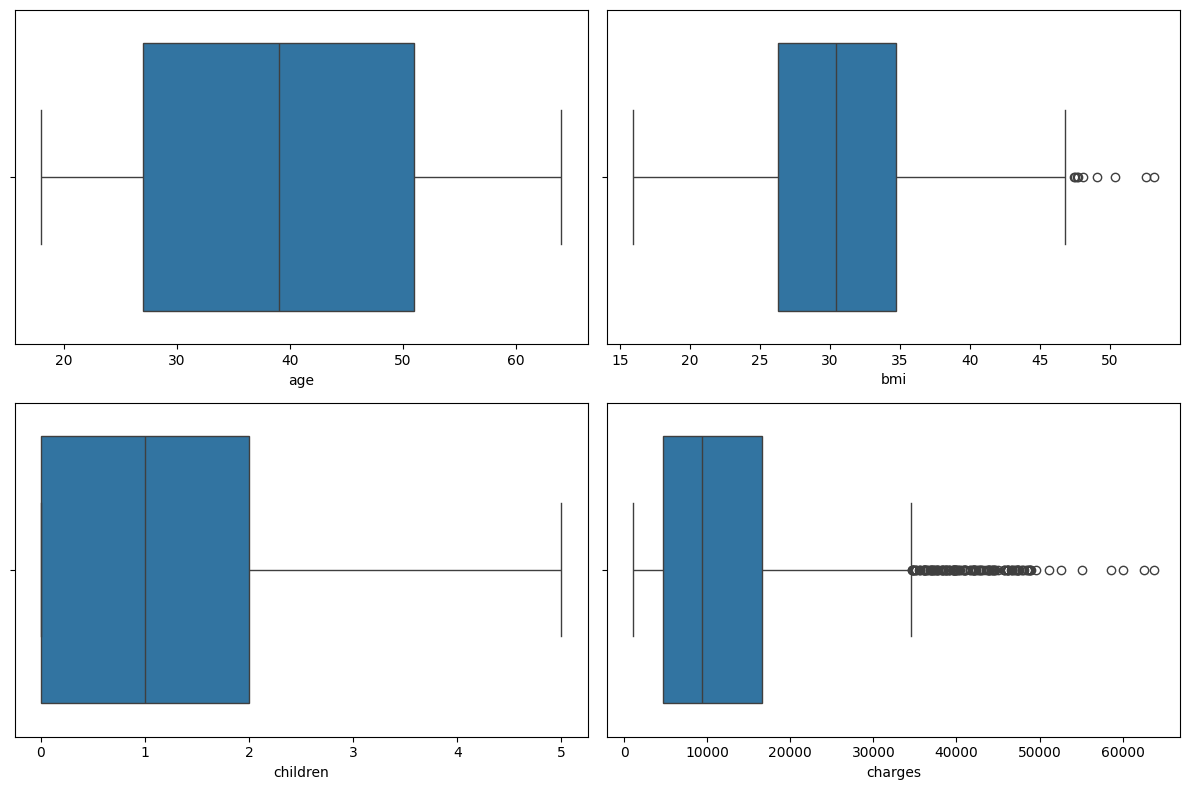

In [14]:
# Create the canvas whereby the plots will be placed
plt.figure(figsize=(12, 8))

# Iterate through the features
for i, column in enumerate(df.select_dtypes(include='number')):
  # Insert a subplot within the canvas
  plt.subplot(2, 2, i + 1)
  # Place a boxplot within the subplot
  sns.boxplot(data=df, x=column)

plt.tight_layout()
plt.show()

## 2. **Data Transformation**
___


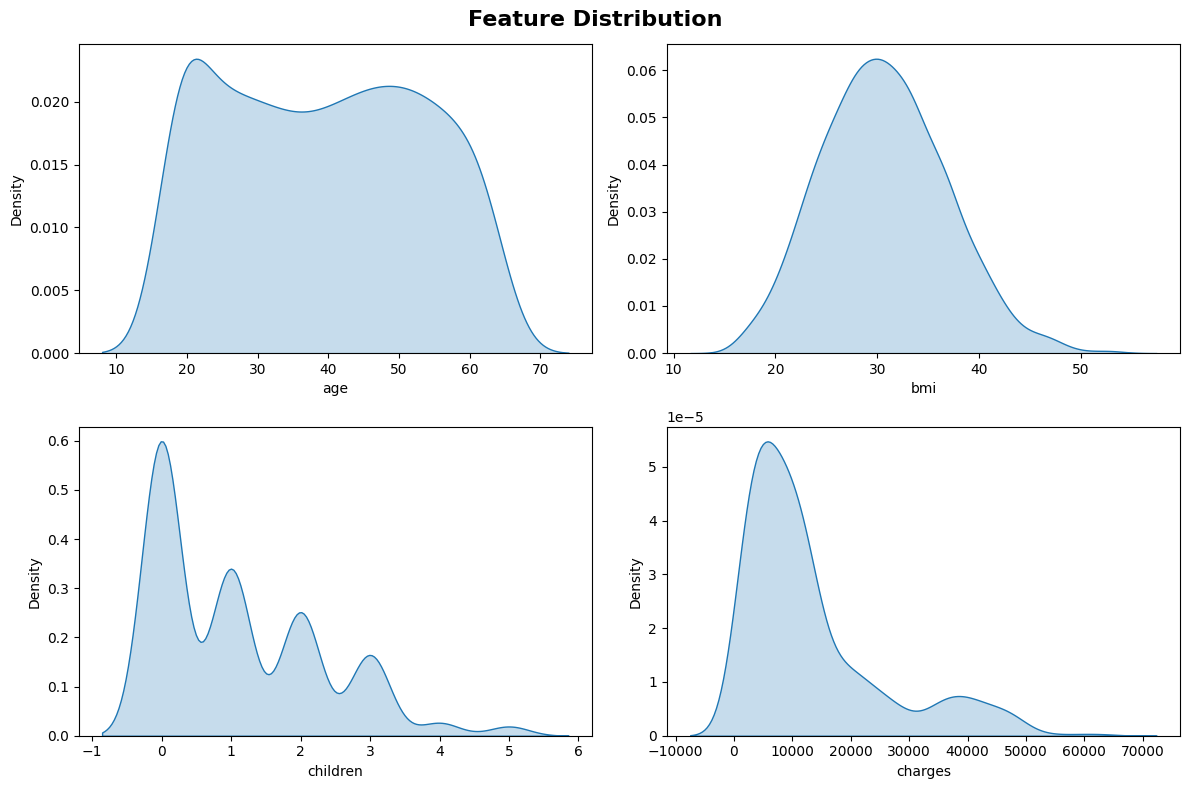

In [15]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(df.select_dtypes(include='number')):
  plt.subplot(2, 2, i + 1)
  sns.kdeplot(df[col], fill=True)
  plt.suptitle('Feature Distribution', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()

In [16]:
def statistics(dataframe: pd.DataFrame) -> None:
    """
    A function that outputs statistics for features with more than 12 unique
    values. The skew and Kurtosis values, along with the p-value from the
    Shapiro-Wilk test. These values help evaluate the distribution of the
    features of the dataframe passed in to the dataframe parameter.

    Args:
        dataframe:
            - A pandas dataframe object.

    Returns:
        None
    """
    for column in dataframe:
      _skew = skew(dataframe[column])
      _kurtosis = kurtosis(dataframe[column], fisher=True)
      print(
          f"\n{column}\n"
          f"skew: {_skew:.4f}\n"
          f"kurtosis: {_kurtosis:.4f}"
      )

      # Perform Shapiro-Wilk test
      stat, p_value = shapiro(dataframe[column])

      # Print the results
      print(f"KS Normality test: {stat:.4f}")
      print(f"P-value: {p_value:.4f}")

      # Interpret the p-value
      alpha = 0.05
      if p_value > alpha:
          print(
              "The data is likely normally distributed (fail to reject H0)."
          )
      else:
          print("The data is not normally distributed (reject H0).")

      # Check the absolute values of each skew value of a feature
      if np.abs(_skew) < 0.5:
          print('distribution is almost symmetrical')
      elif 0.5 <= np.abs(_skew) <= 1:
          print('distribution is modertely skewed')
      else:
          print('distribution is highly skewed')

statistics(df.select_dtypes(include='number'))


age
skew: 0.0556
kurtosis: -1.2449
KS Normality test: 0.9447
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is almost symmetrical

bmi
skew: 0.2837
kurtosis: -0.0550
KS Normality test: 0.9939
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is almost symmetrical

children
skew: 0.9373
kurtosis: 0.1972
KS Normality test: 0.8232
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is modertely skewed

charges
skew: 1.5142
kurtosis: 1.5958
KS Normality test: 0.8147
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is highly skewed


In [17]:
"""
Split the datasets into training and test sets in order to avoid data leakage.
training set must be used to fit the models.
"""

# Split into the dependent and independent variables
X = df.drop(columns='charges')
y = df.loc[:, 'charges']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = (
    train_test_split(X, y, test_size=0.2, random_state=42)
)

"""
During the preprocessing stage, I have seperated the features based on their
distribution to determine the type of preprocessing step to take on the feature
"""

# Categorical Features
categorical_feats = (
    X.select_dtypes(exclude='number').columns.tolist() # Categorical features
)

# Numeric Features
outlier_feats = ['bmi'] # Features with outliers
range_feats = ['children'] # Features with known range of values
gauss_feats = ['age'] # Features whose distribution is almost gaussian

# Create the transformers for each of the feature types
cat_trans = Pipeline(steps=[
    ('onehot',
     OneHotEncoder(drop='first')) # Drop column to avoid multicolinearity
])

robust_trans = Pipeline(steps=[
    ('robust', RobustScaler()) # Apply robust scaling to features with outliers
])

normalization_trans = Pipeline(steps=[
    ('normalization',
     MinMaxScaler()) # Apply normalization to features with known range
])

standardization_trans = Pipeline(steps=[
    ('standardization',
     StandardScaler()) # Apply standardization to features with gaussian distribution
])

# Combine the transformers into a single preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_trans, categorical_feats),
    ('outlier', robust_trans, outlier_feats),
    ('range', normalization_trans, range_feats),
    ('gauss', standardization_trans, gauss_feats)
])

# Enable visualization
set_config(display="diagram")

# Display the pipeline
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['sex', 'smoker', 'region']),
                                ('outlier',
                                 Pipeline(steps=[('robust', RobustScaler())]),
                                 ['bmi']),
                                ('range',
                                 Pipeline(steps=[('normalization',
                                                  MinMaxScaler())]),
                                 ['children']),
                                ('gauss',
                                 Pipeline(steps=[('standardization',
                                                  StandardScaler())]),
                                 ['age'])])

In [18]:
"""
Define the models and hyperparameters. models is a dictionary with the name of
the model being the key value, and a dictionary representing the model and its
hyperparameters being the values.
"""

models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'classifier__n_estimators': [50, 100, 200, 500],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2'],
        }
    },
    'Gradient Boosting Regressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'elasticnet': {
        'model': ElasticNet(random_state=42),
        'params': {
            'classifier__alpha': [0.1, 0.5, 1.0, 5.0],
            'classifier__l1_ratio': [0.2, 0.5, 0.8]
        }
    }
}


In [19]:
"""
Train and process each model in the models dictionary, and apply hyperparameter
tuning (using gridsearchcv) and score using negative mean squared error and
compare the best models
"""

# Initialize variables to track the best model
best_rmse = float('inf')  # Start with an infinite RMSE
best_model = None
best_model_name = ''

# Loop through models
for name, model_info in models.items():
    print(f"Training and tuning {name}...")

    # Create a pipeline with preprocessing + model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_info['model'])
    ])

    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(
        model_pipeline, model_info['params'],
        cv=5, scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Best model and RMSE calculation
    best_predictions = grid_search.best_estimator_.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, best_predictions))
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Test RMSE: {rmse:.2f}")
    print("-" * 50)

    # Track the best model based on lowest RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = grid_search.best_estimator_
        best_model_name = name

Training and tuning Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 500}
Test RMSE: 4428.03
--------------------------------------------------
Training and tuning Gradient Boosting Regressor...
Best parameters for Gradient Boosting Regressor: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Test RMSE: 4329.00
--------------------------------------------------
Training and tuning elasticnet...
Best parameters for elasticnet: {'classifier__alpha': 0.1, 'classifier__l1_ratio': 0.8}
Test RMSE: 5970.45
--------------------------------------------------


In [20]:
# Visualize the steps taken by the best_model
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('outlier',
                                                  Pipeline(steps=[('robust',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('range',
                                                  Pipeline(steps=[('normalization',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('gauss',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('classifier', GradientBoostingRegressor(random_state=42))])

In [21]:
"""
Store the best model and the preprocessor in a pickle file.
"""

if best_model is not None:
    filename = 'best_model_and_preprocessor.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(best_model, file)  # Store preprocessor + trained model

    print(
        f"\nBest model '{best_model_name}' "
        f"with RMSE: {best_rmse:.2f} saved as '{filename}'"
      )
else:
    print("No model was selected.")


Best model 'Gradient Boosting Regressor' with RMSE: 4329.00 saved as 'best_model_and_preprocessor.pkl'
